In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [2]:
from sklearn.linear_model import LogisticRegression as LR
from sklearn.neighbors import KNeighborsClassifier as KNN

In [3]:
def do_Kfold(model,X,y,k,scaler = None, random_state = 146):
    from sklearn.model_selection import KFold
    
    kf = KFold(n_splits=k, random_state = random_state, shuffle=True)

    train_scores = []
    test_scores = []

    for idxTrain, idxTest in kf.split(X):
        Xtrain = X[idxTrain, :]
        Xtest = X[idxTest, :]
        ytrain = y[idxTrain]
        ytest = y[idxTest]
        if scaler != None:
            Xtrain = scaler.fit_transform(Xtrain)
            Xtest = scaler.transform(Xtest)

        model.fit(Xtrain,ytrain)

        train_scores.append(model.score(Xtrain,ytrain))
        test_scores.append(model.score(Xtest,ytest))
        
    return train_scores, test_scores

In [4]:
def compare_classes(actual, predicted, names=None):
    '''Function returns a confusion matrix, and overall accuracy given:
            Input:  actual - a list of actual classifications
                    predicted - a list of predicted classifications
                    names (optional) - a list of class names
    '''
    accuracy = sum(actual==predicted)/actual.shape[0]
    
    classes = pd.DataFrame(columns = ['Actual', 'Predicted'])
    classes['Actual'] = actual
    classes['Predicted'] = predicted

    conf_mat = pd.crosstab(classes['Actual'], classes['Predicted'])
    
    if type(names) != type(None):
        conf_mat.index = names
        conf_mat.index.name = 'Actual'
        conf_mat.columns = names
        conf_mat.columns.name = 'Predicted'
    
    print('Accuracy = ' + format(accuracy, '.2f'))
    return conf_mat, accuracy

In [5]:
def plot_groups(points, groups, colors, 
               ec='black', ax='None',s=30, alpha=0.5,
               figsize=(6,6)):
    '''Creates a scatter plot, given:
            Input:  points (array)
                    groups (an integer label for each point)
                    colors (one rgb tuple for each group)
                    ec (edgecolor for markers, default is black)
                    ax (optional handle to an existing axes object to add the new plot on top of)
            Output: handles to the figure (fig) and axes (ax) objects
    '''
    import matplotlib.pyplot as plt
    import numpy as np
    
    # Create a new plot, unless something was passed for 'ax'
    if ax == 'None':
        fig,ax = plt.subplots(figsize=figsize)
    else:
        fig = plt.gcf()
    
    for i,lbl in enumerate(np.unique(groups)):
        idx = (groups==lbl)
        ax.scatter(points[idx,0], points[idx,1],color=colors[i],
                    ec=ec,alpha=alpha,label = lbl,s=s)
    ax.set_xlabel('$x_1$')
    ax.set_ylabel('$x_2$')
    ax.legend(bbox_to_anchor=[1, 0.5], loc='center left')
    return fig, ax

In [6]:
def get_colors(N, map_name='rainbow'):
    '''Returns a list of N colors from a matplotlib colormap
            Input: N = number of colors, and map_name = name of a matplotlib colormap
    
            For a list of available colormaps: 
                https://matplotlib.org/3.1.1/gallery/color/colormap_reference.html
    '''
    import matplotlib
    cmap = matplotlib.cm.get_cmap(name=map_name)
    n = np.linspace(0,1,N)
    colors = cmap(n)
    return colors

## Part 1: Two class problem with one predictor (Wine)

We will start by looking at a simplification of the wine data - we will consider two classes: Class_2 and Not_Class_2, and a single predictor, flavanoids.

In [7]:
data = pd.read_csv('data/wine_data.csv')
data.head()

,alcohol,malic_acid,ash,alcalinity_of_ash,magnesium,total_phenols,flavanoids,nonflavanoid_phenols,proanthocyanins,color_intensity,hue,od280/od315_of_diluted_wines,proline,target
0,14.23,1.71,2.43,15.6,127,2.80,3.06,0.28,2.29,5.64,1.04,3.92,1065,Cultivar_1
1,13.20,1.78,2.14,11.2,100,2.65,2.76,0.26,1.28,4.38,1.05,3.40,1050,Cultivar_1
2,13.16,2.36,2.67,18.6,101,2.80,3.24,0.30,2.81,5.68,1.03,3.17,1185,Cultivar_1
3,14.37,1.95,2.50,16.8,113,3.85,3.49,0.24,2.18,7.80,0.86,3.45,1480,Cultivar_1
4,13.24,2.59,2.87,21.0,118,2.80,2.69,0.39,1.82,4.32,1.04,2.93,735,Cultivar_1


In [8]:
X_df = data.drop(columns = 'target')
X_df.shape

(178, 13)

In [9]:
y = data['target'].values #this makes it an array

In [10]:
#for now, make this a binary problem
#and just have one predictor
col = 'flavanoids'
X_one = X_df[col]
y_bin = np.array([value if value == 'Cultivar_3' else 'Not_Cultivar_3' for value in y])

In [11]:
#Just for the purpose of plotting
plot_df = pd.DataFrame(X_one, columns = ['flavanoids'])
plot_df['target'] = y_bin

In [12]:
plot_df['target'].value_counts()

target
Not_Cultivar_3    130
Cultivar_3         48
Name: count, dtype: int64

/tmp/ipykernel_173/3013171931.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.stripplot(data = plot_df, y = 'target', x = 'flavanoids',
/opt/conda/lib/python3.11/site-packages/seaborn/_base.py:949: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)


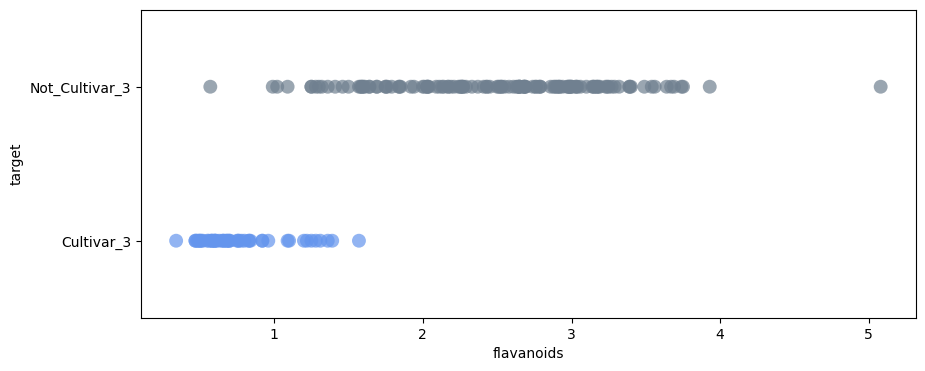

In [15]:
import seaborn as sns
plt.figure(figsize = [10,4])
sns.stripplot(data = plot_df, y = 'target', x = 'flavanoids', 
              palette=['slategrey', 'cornflowerblue'],
             s = 10, alpha = 0.7,  jitter = False)
plt.show()

In [20]:
#Create and fit model
log_reg = LR()
log_reg.fit(X_one.values.reshape(-1,1), y_bin)

LogisticRegression()

In [23]:
log_reg.score(X_one.values.reshape(-1,1), y_bin)

0.9382022471910112

In [24]:
#A few example predictions
log_reg.predict(X_one[60:65].values.reshape(-1,1))

array(['Cultivar_3', 'Not_Cultivar_3', 'Not_Cultivar_3', 'Not_Cultivar_3',
       'Not_Cultivar_3'], dtype='<U14')

In [25]:
log_reg.predict_proba(X_one[60:65].values.reshape(-1,1))

array([[0.61457939, 0.38542061],
       [0.33249995, 0.66750005],
       [0.11119829, 0.88880171],
       [0.0010672 , 0.9989328 ],
       [0.1264055 , 0.8735945 ]])

In [26]:
#Let's fit model to new data, flavanoids from 0 to 5 (some code from Machine Learning book)
#Really we are just using this to construct the curves below
X_new = np.linspace(0,5,1000)
y_proba = log_reg.predict_proba(X_new.reshape(-1,1))

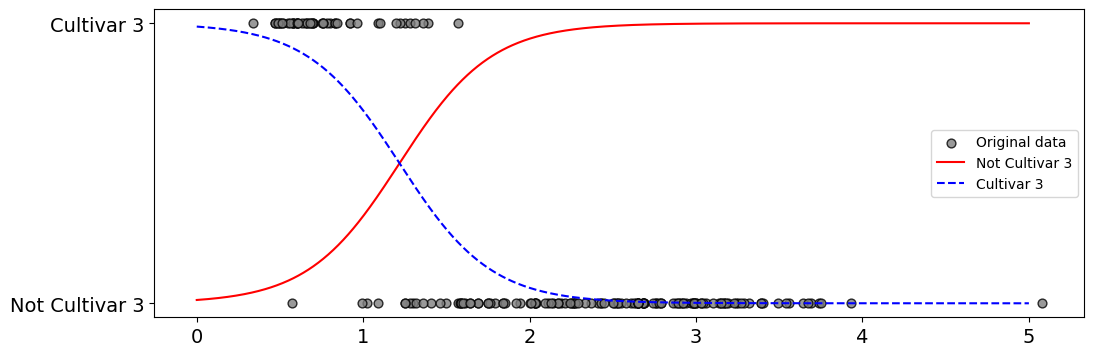

In [27]:
#this code is just so we have a plot to look at
#it's never anything you'd be asked to do  on your own for homeworks
plt.figure(figsize = [12,4])
plt.scatter(X_one,y_bin, ec = 'k', c = 'grey', label = 'Original data', s = 40, alpha = 0.8)
plt.plot(X_new, y_proba[:,1], 'r-', label = 'Not Cultivar 3')
plt.plot(X_new, y_proba[:,0], 'b--', label = 'Cultivar 3')
plt.yticks([0,1], ['Not Cultivar 3', 'Cultivar 3'],fontsize = 14)
plt.xticks(fontsize = 14)
colors = ['blue','red']
plt.legend()
plt.show()

In [188]:
#Yes, this is all of the data
#We are just using this for exploratory purposes
#Not building a final model
compare_classes(y_bin, log_reg.predict(X_one.values.reshape(-1,1)))

Accuracy = 0.94


(Predicted       Cultivar_3  Not_Cultivar_3
 Actual                                    
 Cultivar_3              41               7
 Not_Cultivar_3           4             126,
 0.9382022471910112)

## Part 2: Two class problem, all predictors (Wine)

We will look at a single test-train split.

/opt/conda/lib/python3.11/site-packages/seaborn/_base.py:949: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)


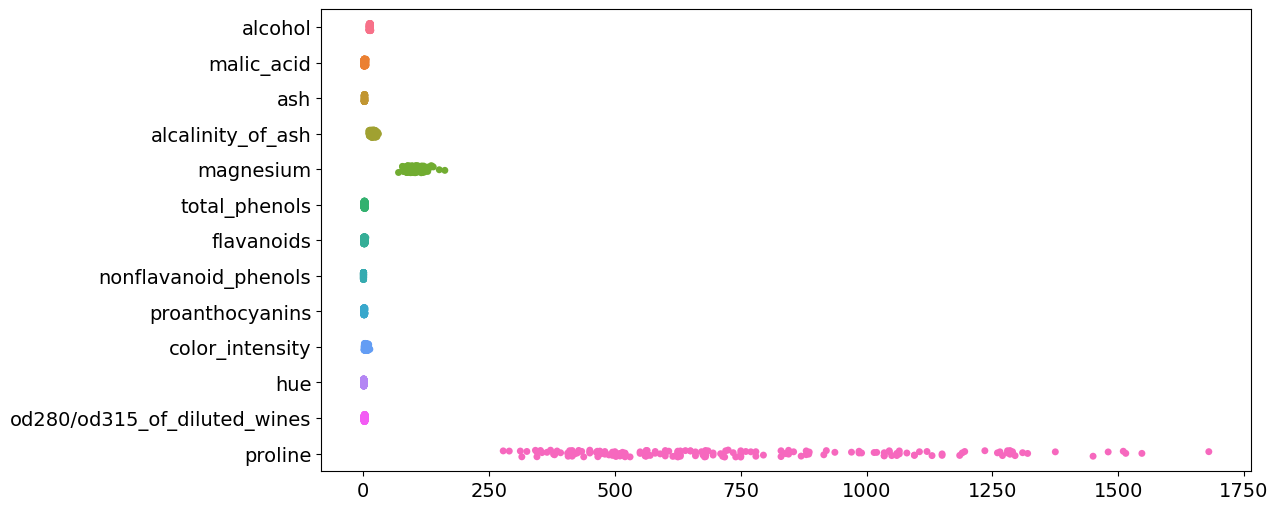

In [28]:
plt.figure(figsize = [12,6])
sns.stripplot(data = X_df, orient = 'h')
plt.xticks(fontsize = 14)
plt.yticks(fontsize = 14)
plt.show()

In [29]:
X = np.array(X_df)

In [30]:
from sklearn.model_selection import train_test_split as tts
from sklearn.preprocessing import StandardScaler as SS

Xtrain,Xtest,ytrain,ytest = tts(X,y_bin,test_size=0.4, random_state=146)

In [31]:
# Standardize the data
ss = SS()
Xtrain_s = ss.fit_transform(Xtrain)
Xtest_s = ss.transform(Xtest)

In [32]:
# Fit the model
log_reg = LR()
log_reg.fit(Xtrain_s, ytrain)

LogisticRegression()

In [33]:
#Score on training data (we will do test data below)
log_reg.score(Xtrain_s, ytrain)

1.0

In [34]:
# Generate our predictions for the test set
y_pred = log_reg.predict(Xtest_s)

# Look at the confusion matrix
compare_classes(ytest, y_pred)



Accuracy = 0.99


(Predicted       Cultivar_3  Not_Cultivar_3
 Actual                                    
 Cultivar_3              15               1
 Not_Cultivar_3           0              56,
 0.9861111111111112)

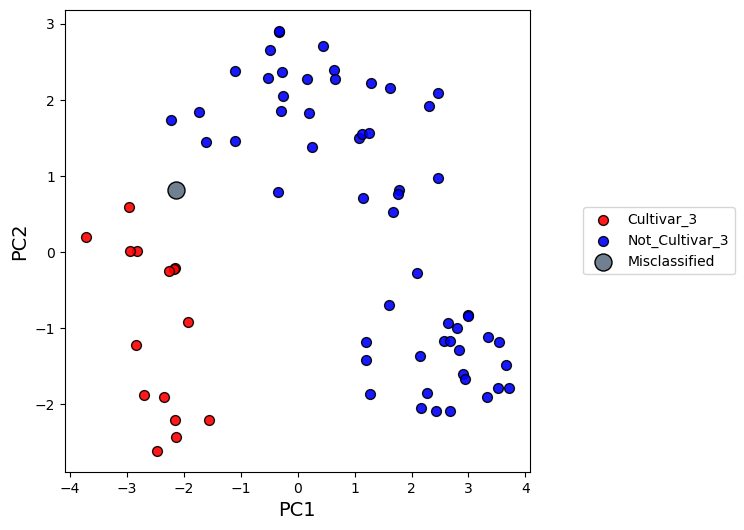

In [37]:
from sklearn.decomposition import PCA
c = ['red', 'blue']
pca = PCA(n_components = 2)
Xtrain_pca = pca.fit_transform(Xtrain_s)
Xtest_pca = pca.transform(Xtest_s)
#fig,ax = plot_groups(Xtrain_pca, ytrain, c)
fig,ax = plot_groups(Xtest_pca, y_pred, c, alpha = 0.9, s = 50)
idx_wrong = ytest != y_pred
plot_groups(Xtest_pca[idx_wrong], y_pred[idx_wrong], ['slategrey'], alpha = 1, s = 150, ax = ax)
plt.xlabel('PC1', fontsize = 14)
plt.ylabel('PC2', fontsize = 14)
ax.legend(labels = ['Cultivar_3', 'Not_Cultivar_3', 'Misclassified'], bbox_to_anchor = [1.1, 0.5], loc = 'center left')
plt.show()

## Part 3: All predictors, multi (3) class problem

In [38]:
X = np.array(X_df)

In [40]:
#Let's use k-fold validation first to evaluate overall performance
tr,te = do_Kfold(LR(),X,y,10,SS())

/opt/conda/lib/python3.11/site-packages/seaborn/_base.py:949: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)


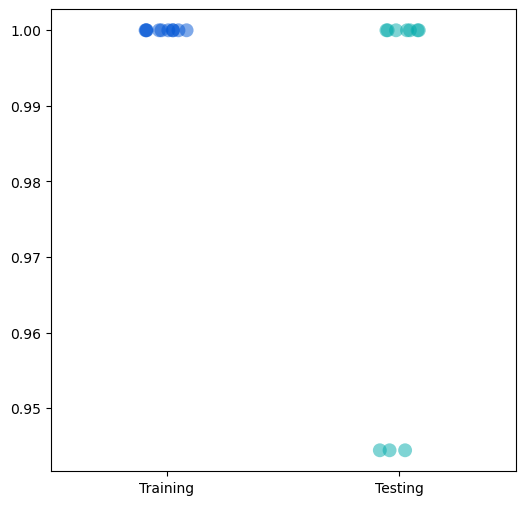

In [41]:
plt.figure(figsize = (6,6))
sns.stripplot(data = pd.DataFrame(zip(tr,te), columns = ['Training', 'Testing']), size=10, palette = 'winter',
             alpha = 0.5, jitter = True)
plt.show()

## Part 4: Compare with kNN

We will compare performance with kNN using a single train-test split. Note that we will make some plots of misclassifications...in the homework you should NOT be making plots to assess this - use the confusion matrix.

In [42]:
Xtrain,Xtest,ytrain,ytest = tts(X,y,test_size=0.4, random_state=146, shuffle = True)

# Standardize the data
ss = SS()
Xtrain_s = ss.fit_transform(Xtrain)
Xtest_s = ss.transform(Xtest)

In [44]:
# Fit the model
log_reg = LR()
log_reg.fit(Xtrain_s, ytrain)

LogisticRegression()

In [45]:
#Score on training set
#Get confusion matrix for training set
print(log_reg.score(Xtrain_s, ytrain))
compare_classes(ytrain, log_reg.predict(Xtrain_s))

1.0
Accuracy = 1.00


(Predicted   Cultivar_1  Cultivar_2  Cultivar_3
 Actual                                        
 Cultivar_1          35           0           0
 Cultivar_2           0          39           0
 Cultivar_3           0           0          32,
 1.0)

In [46]:
#Score on test set
print(log_reg.score(Xtest_s, ytest))
# Generate our predictions for the test set
y_pred = log_reg.predict(Xtest_s)

# Look at the confusion matrix
compare_classes(ytest, y_pred)

0.9861111111111112
Accuracy = 0.99


(Predicted   Cultivar_1  Cultivar_2  Cultivar_3
 Actual                                        
 Cultivar_1          24           0           0
 Cultivar_2           0          32           0
 Cultivar_3           0           1          15,
 0.9861111111111112)

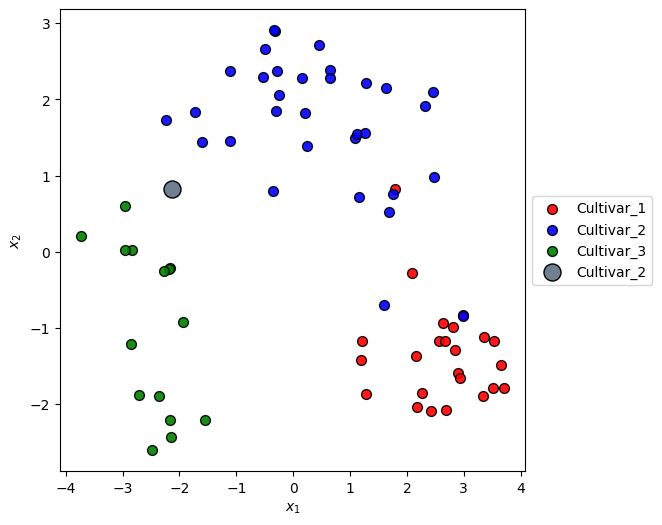

In [47]:
#plot of misclassifications on the test set
from sklearn.decomposition import PCA
c = ['red', 'blue', 'green']
pca = PCA(n_components = 2)
Xtrain_pca = pca.fit_transform(Xtrain_s)
Xtest_pca = pca.transform(Xtest_s)
#fig,ax = plot_groups(Xtrain_pca, ytrain, c)
fig,ax = plot_groups(Xtest_pca, y_pred, c, alpha = 0.9, s = 50)
idx_wrong = ytest != y_pred
plot_groups(Xtest_pca[idx_wrong], y_pred[idx_wrong], ['slategrey'], alpha = 1, s = 150, ax = ax, 
            )
plt.show()

In [48]:
#Step 1 - get best cross-validated kNN model
neighbor_range = np.array(range(2,20))

train=[]
test=[]

k = 10

for n_neighbors in neighbor_range:
    knn = KNN(n_neighbors=n_neighbors, weights = 'distance')
    tr,te = do_Kfold(knn,X,y,k, SS())
    
    train.append(np.mean(tr))
    test.append(np.mean(te))

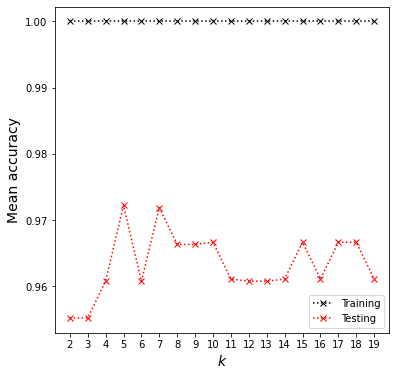

In [55]:
plt.figure(figsize=(6,6))
plt.plot(neighbor_range, train, ':xk', label='Training')
plt.plot(neighbor_range, test, ':xr', label='Testing')
plt.ylabel('Mean accuracy', fontsize=14)
plt.xlabel('$k$',fontsize=14)
plt.xticks(neighbor_range)
plt.legend()
plt.show()

In [49]:
idx = test == np.max(test)
print(neighbor_range[idx])
print(np.max(test))

[5]
0.9722222222222221


In [50]:
#Make the KNN classifier
knn = KNN(n_neighbors = 5, weights = 'distance')

In [52]:
#Use the same training and test data from the same tts
knn.fit(Xtrain_s, ytrain)

KNeighborsClassifier(weights='distance')

In [53]:
#Score on training set
#Get confusion matrix for training set
print(knn.score(Xtrain_s, ytrain))
compare_classes(ytrain, knn.predict(Xtrain_s))

1.0
Accuracy = 1.00


(Predicted   Cultivar_1  Cultivar_2  Cultivar_3
 Actual                                        
 Cultivar_1          35           0           0
 Cultivar_2           0          39           0
 Cultivar_3           0           0          32,
 1.0)

In [54]:
#Score on test set
print(knn.score(Xtest_s, ytest))
# Generate our predictions for the test set
y_pred = knn.predict(Xtest_s)

# Look at the confusion matrix
compare_classes(ytest, y_pred)

0.9305555555555556
Accuracy = 0.93


(Predicted   Cultivar_1  Cultivar_2  Cultivar_3
 Actual                                        
 Cultivar_1          24           0           0
 Cultivar_2           4          27           1
 Cultivar_3           0           0          16,
 0.9305555555555556)

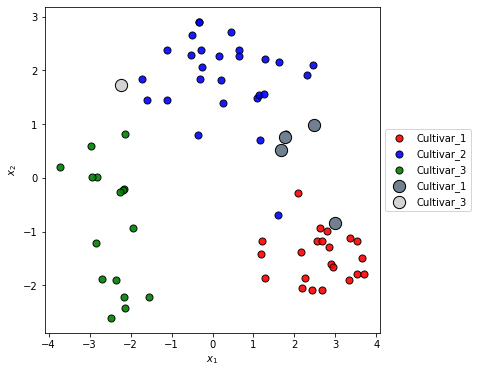

In [69]:
from sklearn.decomposition import PCA
c = ['red', 'blue', 'green']
pca = PCA(n_components = 2)
Xtrain_pca = pca.fit_transform(Xtrain_s)
Xtest_pca = pca.transform(Xtest_s)
#fig,ax = plot_groups(Xtrain_pca, ytrain, c)
fig,ax = plot_groups(Xtest_pca, y_pred, c, alpha = 0.9, s = 50)
idx_wrong = ytest != y_pred
plot_groups(Xtest_pca[idx_wrong], y_pred[idx_wrong],['slategrey','lightgrey'], alpha = 1, s = 150, ax = ax, 
            )
plt.show()